In [17]:
import h5py
import copy
import tqdm
import lmfit
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from rich.progress import Progress
from scipy.stats import binned_statistic
from utils.plot_utils import set_fontsize
from utils.hdf_utils import load_measurement_data_devices_attrs

In [5]:
hdf_dir = Path(".")

In [6]:
yag_channel = 0
pmt_channel = 1
pd_channel = 2
pdn_channel = 3

In [99]:
fname = "2021_3_2.hdf"

with h5py.File(hdf_dir / fname, 'r') as f:
    dset_names = list(f.keys())
dset_names

['1614700966 find R0 F1',
 '1614702091 R0 F1 saturation 23 mW',
 '1614702994 alignment check center window',
 '1614704952 alignment check center window',
 '1614704992 alignment check center window',
 '1614705973 find Q4 absorption with R0 F1 fluorescence',
 '1614705995 find Q4 absorption with R0 F1 fluorescence',
 '1614707432 find Q4 absorption with R0 F1 fluorescence',
 '1614708145 find Q4 absorption with R0 F1 fluorescence',
 '1614708522 correlation check R0 F1 fluorescence Q4 absorption',
 '1614709220 correlation check R0 F1 fluorescence Q4 absorption no lowpass',
 '1614709368 correlation check R0 F1 fluorescence Q4 absorption no lowpass',
 '1614714999 correlation check R0 F1 fluorescence Q4 absorption no lowpass',
 '1614715288 correlation check R0 F1 fluorescence Q4 absorption no lowpass',
 '1614716135 correlation check R0 F1 fluorescence Q4 absorption 5 mm up from center',
 '1614716813 correlation check R0 F1 fluorescence Q4 absorption 5 mm down from center',
 '1614723484 correlat

In [100]:
dset_name = "1614702994 alignment check center window"
devices = ()

In [102]:
dset_names_saturation = [dname for dname in dset_names if 'saturation scan' in dname]
# remove last entry; different alignment
dset_names_saturation = dset_names_saturation[:-1]
# remove duplicate entry; empty dataset
dset_names_saturation.remove('1614726006 saturation scan R0 F1 fl with Q4 abs 40 mW')

# get scan powers
powers = [float(dname.split(' ')[-2]) for dname in dset_names_saturation]

dset_names_saturation

['1614723883 saturation scan R0 F1 fl with Q4 abs 21.7 mW',
 '1614725156 saturation scan R0 F1 fl with Q4 abs 30 mW',
 '1614726026 saturation scan R0 F1 fl with Q4 abs 40 mW',
 '1614731131 saturation scan R0 F1 fl with Q4 abs 50 mW',
 '1614732672 saturation scan R0 F1 fl with Q4 abs 57 mW',
 '1614733915 saturation scan R0 F1 fl with Q4 abs 10 mW',
 '1614738056 saturation scan R0 F1 fl with Q4 abs 63 mW']

In [105]:
slice_flm  = np.s_[100:250]
slice_absm = np.s_[-750:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

yag_cutoff = 500
pdn_cutoff = 12000
abs_integral_cutoff = 1.5

scan_attr = 'Laser Lock 1 SetLockPointSeed2'

In [104]:
bins = np.arange(-241, -223, 1) - 0.5
scan_data = dict([(p, []) for p in powers])
scan_data_normalized = dict([(p, []) for p in powers])
                
with Progress() as progress:
    task = progress.add_task("[green]Processing...", total = len(powers))
    for power, dset_name in zip(powers, dset_names_saturation):
        pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(fname, dset_name, devices)

        scan_parameters = np.array([pxie_attrs[idx][scan_attr] for idx in range(1,len(pxie)+1)])

        yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
        pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
        pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
        pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
        norm_data = -pd_data/pdn_data
        
        absorption_integral = np.trapz((norm_data - norm_data[:,slice_absm].mean(axis = 1)[:,np.newaxis])[:,slice_absi], axis = 1)
        abs_cut = absorption_integral < abs_integral_cutoff
        yag_cut = yag_data.max(axis = 1) < yag_cutoff
        pdn_cut = pdn_data.max(axis = 1) < pdn_cutoff
        
        mask_cuts = yag_cut | pdn_cut | abs_cut
        
        pmt_data[mask_cuts] = np.nan
        norm_data[mask_cuts] = np.nan
        
        pmt_data_norm = pmt_data - np.nanmean(pmt_data[:,slice_flm], axis=1)[:,np.newaxis]
        norm_data_norm = norm_data - np.nanmean(norm_data[:,slice_absm], axis=1)[:,np.newaxis]
        
        fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
        absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

        stat, bin_edges, bin_number = binned_statistic(
                                            scan_parameters, 
                                            fluorescence_integral / absorption_integral, 
                                            statistic = lambda x: np.nanmean(x), 
                                            bins = bins)
        
        err, _, _ = binned_statistic(scan_parameters, 
                                    fluorescence_integral / absorption_integral, 
                                    statistic = lambda x: np.nanstd(x)/np.sqrt(len(x)-1), 
                                    bins = bins)

        bin_means = bin_edges[:-1]+np.diff(bin_edges)[0]

        scan_data_normalized[power] = (bin_means, stat, err)
        
        stat, bin_edges, bin_number = binned_statistic(
                                            scan_parameters, 
                                            fluorescence_integral, 
                                            statistic = lambda x: np.nanmean(x), 
                                            bins = bins)
        
        err, _, _ = binned_statistic(
                                    scan_parameters, 
                                    fluorescence_integral, 
                                    statistic = lambda x: np.nanstd(x)/np.sqrt(len(x)-1), 
                                    bins = bins)

        bin_means = bin_edges[:-1]+np.diff(bin_edges)[0]/2

        scan_data[power] = (bin_means, stat, err)
        
        progress.update(task, advance = 1)
        progress.refresh()

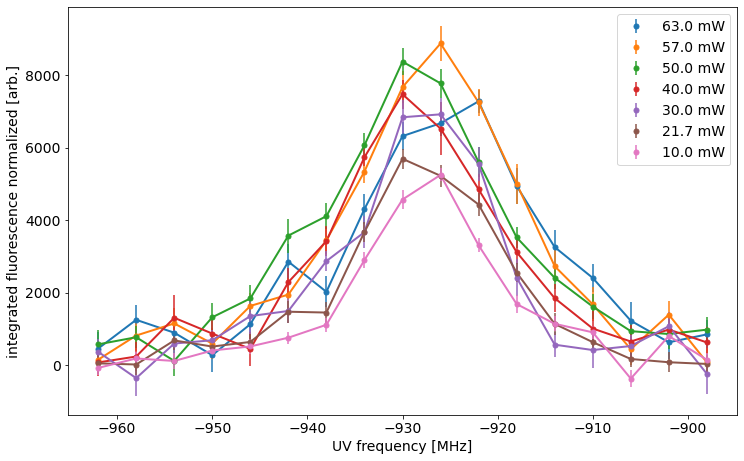

In [114]:
fig, ax = plt.subplots(figsize = (12,7.5))

for power in sorted(powers)[::-1]:
    bins, values, err = scan_data_normalized[power]
    l = ax.plot(4*bins, values, lw = 2)
    ax.errorbar(4*bins, values, yerr = err, fmt = '.', label = f'{power:.1f} mW', ms = 10,
               color = l[0].get_color())

    ax.legend(fontsize = 14)
    
ax.set_xlabel('UV frequency [MHz]')
ax.set_ylabel('integrated fluorescence normalized [arb.]')

set_fontsize(ax, 14)

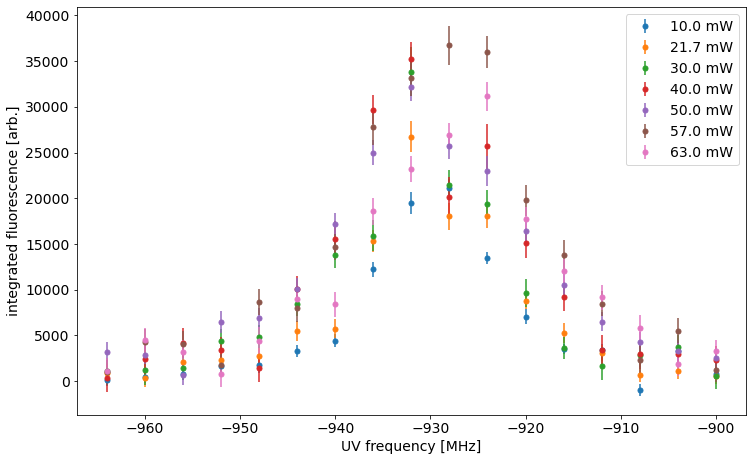

In [115]:
fig, ax = plt.subplots(figsize = (12,7.5))

for power in sorted(powers):
    bins, values, err = scan_data[power]
    ax.errorbar(4*bins, values, yerr = err, fmt = '.', label = f'{power:.1f} mW', ms = 10)

    ax.legend(fontsize = 14)
    
ax.set_xlabel('UV frequency [MHz]')
ax.set_ylabel('integrated fluorescence [arb.]')

set_fontsize(ax, 14)

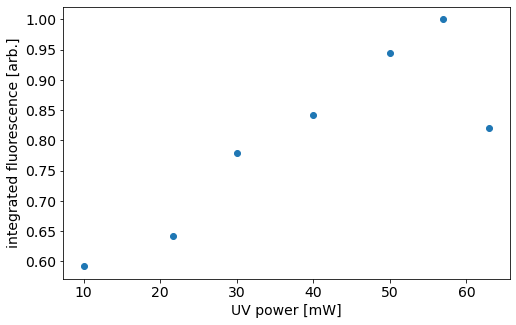

In [126]:
# this only works because I know the central value in maximal (from the plots above)
# use indexing to be sure to grab the central value when this is not the case
central_value = [np.nanmax(scan_data_normalized[power][1]) for power in powers]

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(powers, central_value/max(central_value), '.', ms = 12)

ax.set_xlabel('UV power [mW]')
ax.set_ylabel('integrated fluorescence [arb.]')
set_fontsize(ax, 14)

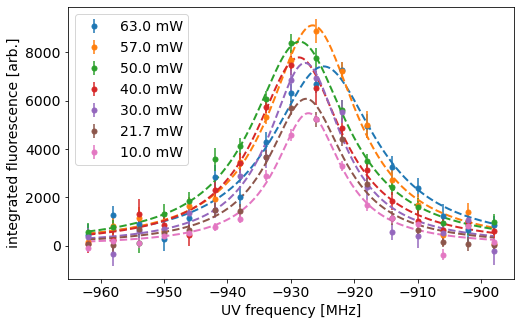

In [157]:
fit_model = lmfit.models.LorentzianModel()
params = fit_model.make_params()


fits = {}

fig, ax = plt.subplots(figsize = (8,5))
for idx, power in enumerate(sorted(powers)[::-1]):
    bins, values, err = scan_data_normalized[power]
    bins = 4*bins
    x = np.linspace(bins.min(), bins.max(), 201)
    
    params.add('amplitude', np.nanmax(values))
    params.add('center', bins[np.nanargmax(values)])
    params.add('sigma', 8)

    mask_notnan = ~np.isnan(values)
    result = fit_model.fit(values[mask_notnan], 
                           params, 
                           weights = 1/err[mask_notnan],
                           x = bins[mask_notnan])
    
    l = ax.plot(x, result.eval(x = x), ls = '--', lw = 2)
    ax.errorbar(bins, values, yerr = err, 
                ms = 10, fmt = '.', ecolor = l[0].get_color(), color = l[0].get_color(),
                label = f'{power:.1f} mW'
               )
    
    fits[power] = result
    
ax.set_xlabel('UV frequency [MHz]')
ax.set_ylabel('integrated fluorescence [arb.]')
ax.legend(fontsize = 14)

set_fontsize(ax, 14)

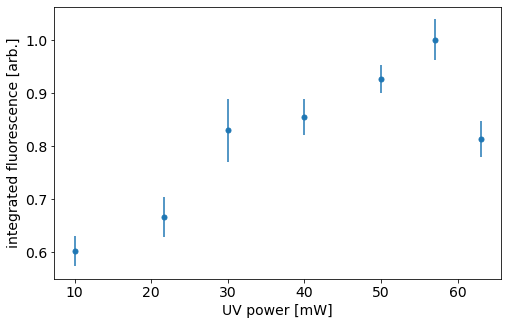

In [163]:
y = np.array([fits[power].params['height'].value for power in powers])
yerr = np.array([fits[power].params['height'].stderr for power in powers])/y.max()

y /= y.max()

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(powers, y, yerr = yerr, fmt = '.', ms = 10)

ax.set_xlabel('UV power [mW]')
ax.set_ylabel('integrated fluorescence [arb.]')
set_fontsize(ax, 14)

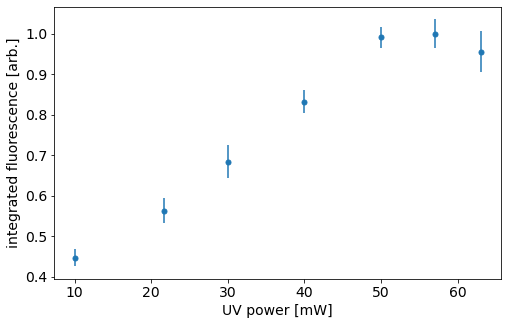

In [161]:
y = np.array([fits[power].params['amplitude'].value for power in powers])
yerr = np.array([fits[power].params['amplitude'].stderr for power in powers])/y.max()

y /= y.max()

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(powers, y, yerr = yerr, fmt = '.', ms = 10)

ax.set_xlabel('UV power [mW]')
ax.set_ylabel('integrated fluorescence [arb.]')
set_fontsize(ax, 14)

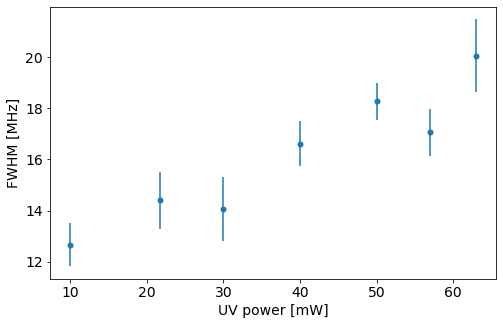

In [159]:
y = np.array([fits[power].params['fwhm'].value for power in powers])
yerr = np.array([fits[power].params['fwhm'].stderr for power in powers])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(powers, y, yerr = yerr, fmt = '.', ms = 10)

ax.set_xlabel('UV power [mW]')
ax.set_ylabel('FWHM [MHz]')
set_fontsize(ax, 14)

In [160]:
for p,f in fits.items():
    print(f'{p:.1f} mW -> redch = {f.redchi:.1f}')

63.0 mW -> redch = 1.5
57.0 mW -> redch = 1.0
50.0 mW -> redch = 0.7
40.0 mW -> redch = 0.8
30.0 mW -> redch = 1.8
21.7 mW -> redch = 1.9
10.0 mW -> redch = 2.0
